In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import scipy.stats as sps

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

os.chdir("E:/200_CASA/07_QM")
os.getcwd()

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('science') # specifies that graphs should use ggplot styling

In [3]:
df = pd.read_csv("./data/coursework_1_data_2019.csv").convert_dtypes()
dfc = df.copy() ## data frame copied

* 因变量分布 plot  分性别
* 因变量处理
    * 对数化
    * outliers
* 关系 plot
    * 幂律关系
    * Optional: boxplot 分布
* 模型假设
    * 常数项？+ 性别比例+区域+权利机构+投资额 = obesity cases
    * 回归
* 结果
    * 投资额
    * 性别影响
    * 区域差异
* 讨论与结论
    * 

# Functions


In [4]:
# outliers detecter
def outlier_detect(data,threshold=3,method="IQR"):
    IQR = data.quantile(0.75) - data.quantile(0.25)
    Lower_fence = data.quantile(0.25) - (IQR * threshold)
    Upper_fence = data.quantile(0.75) + (IQR * threshold)

    para = (Upper_fence, Lower_fence)
    print(para)
    tmp = pd.concat([data>Upper_fence,data<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    print('Num of outlier detected:',outlier_index.value_counts()[1])
    print('Proportion of outlier detected',outlier_index.value_counts()[1]/len(outlier_index))

    return outlier_index, para



def drop_column_using_vif_(df, thresh=40):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print(f'Dropping: {index_to_drop}\n VIF_value:{vif_df.VIF.max()}')
            print("=="*20)
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [120]:
def transform_for_regression(df,y,dicx):
    '''
    pick and transform data columns from the given dataframe df
    
    y: dependent variable
    dicx: independent variables
    '''
    dft = pd.DataFrame()
    
    variables = y["var"]
    if y["method"] == "log":
        dft["y"] = df.apply(lambda x : np.log(x[variables]), axis=1)
    elif y["method"] == "delta":
        dft["y"] = df.apply(lambda x : x[variables[0]] - x[variables[1]], axis=1)          
    elif y["method"] == "deltalog":
        dft["y"] = df.apply(lambda x : np.log(x[variables[0]] - x[variables[1]]), axis=1)   
    elif y["method"] == "ratedelta":
        dft["y"] = df.apply(lambda x : 1000*(x[variables[0]]/x[variables[1]]-x[variables[2]]/x[variables[3]]), axis=1)

    ## x 
    if len(dicx["source"]) != 0:
        for k,v in dicx["source"].items():
            dft[k] = df[v]

    if len(dicx["log"]) != 0:
        for k,v in dicx["log"].items():
            dft[k] = df.apply(lambda x : np.log(x[v]) ,axis=1)

    if len(dicx["rate"]) != 0:
        for k,v in dicx["rate"].items():
            dft[k] = df.apply(lambda x:x[k]/x[v],axis=1) # avoid div0

    if len(dicx["category"]) != 0:
        for k,v in dicx["category"].items():
            dft[k] = df[v].astype("category")
            dft = pd.get_dummies(dft)

    return dft

# Main Model

## Outliers

In [115]:
dt = np.log(dfc["2018_cases_total"])
index,para = outlier_detect(dt,threshold=1.5,method="IQR")
print(np.where(index==True))

(8.93144610294618, 4.856009317803286)
Num of outlier detected: 3
Proportion of outlier detected 0.019736842105263157
(array([ 25,  59, 105], dtype=int64),)


In [116]:
dfc[index]

,local_authority_area,2008_cases_total,2013_cases_total,2018_cases_total,2008_pop_total,2013_pop_total,2018_pop_total,2008_cases_male,2013_cases_male,2018_cases_male,...,2018_pop_female,total_budget,clean_air,clean_environ,health_training,school_awareness,media_awareness,sub_counselling,region,local_authority_type
25,City of London,16,14,12,11378,9838,8107,5,3,3,...,3711,50000,12000,9000,6000,20000,2000,1000,London,other_london
59,Isles of Scilly,5,1,4,2200,2385,2440,2,0,1,...,1014,2000,0,0,0,2000,0,0,South West,unitary_authority
105,Rutland,88,102,86,38363,39872,42952,28,23,26,...,19756,51000,17000,5000,8000,14000,5000,2000,East Midlands,unitary_authority


In [117]:
# outlier retention
index[105]=False
# [25,  59] 
# outlier drop
dfs = dfc[~index].reset_index(drop=True) ## data frame source 

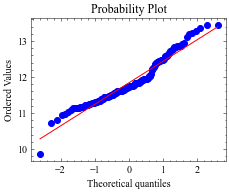

In [118]:
res = sps.probplot(np.log(dfs["2008_pop_male"]),plot=plt)

关系

## Explore distribution and relationship

## variables and transform

In [10]:
# dependent variables transform
y = {"method":"delta",
     "var" : ["2018_cases_total","2008_cases_total"]}

y = {"method":"deltalog",
     "var" : ["2018_cases_total","2008_cases_total"]}

y = {"method":"log",
     "var" : "2018_cases_total"}

y = {"method":"ratedelta",
     "var" : ["2018_cases_total","2018_pop_total","2008_cases_total","2008_pop_total"]}

# independent variables transform
dicx = {}
## independent variables to keep
dicx["source"]  = {}
## independent variables to be logged 
dicx["log"] = {'2018_pop_total':"2018_pop_total",
               "total_budget" : "total_budget",
               'clean_air':'clean_air', 
               'clean_environ':'clean_environ',
               'health_training':'health_training',
               'school_awareness': 'school_awareness',
               'media_awareness':'media_awareness', 
               'sub_counselling':'sub_counselling'
              }
## independent categorical variables
dicx["category"] ={'r':"region","lcattype" : "local_authority_type"}
dicx["rate"] = {} #{'clean_air':"total_budget","clean_environ":"total_budget"}
print(f"variables:{dicx},\ny:{y}")

variables:{'source': {}, 'log': {'2018_pop_total': '2018_pop_total', 'total_budget': 'total_budget', 'clean_air': 'clean_air', 'clean_environ': 'clean_environ', 'health_training': 'health_training', 'school_awareness': 'school_awareness', 'media_awareness': 'media_awareness', 'sub_counselling': 'sub_counselling'}, 'category': {'r': 'region', 'lcattype': 'local_authority_type'}, 'rate': {}},
y:{'method': 'ratedelta', 'var': ['2018_cases_total', '2018_pop_total', '2008_cases_total', '2008_pop_total']}


## 模型一： 发病率的变化

In [485]:
#sns.boxplot(data=dfs,x="region",y="2018_cases_total")

In [484]:
# model = sm.OLS(endog=dft[["school_awareness"]], exog=dft[['r_London',
#        'r_North East', 'r_North West', 'r_South East', 'r_South West',
#        'r_West Midlands', 'r_Yorkshire and the Humber']], hasconst=False).fit()
#print(model.summary())

variables:{'source': {}, 'log': {'2018_pop_total': '2018_pop_total', 'clean_air': 'clean_air', 'clean_environ': 'clean_environ', 'health_training': 'health_training', 'school_awareness': 'school_awareness', 'media_awareness': 'media_awareness', 'sub_counselling': 'sub_counselling'}, 'category': {'r': 'region'}, 'rate': {}},
y:{'method': 'ratedelta', 'var': ['2018_cases_total', '2018_pop_total', '2008_cases_total', '2008_pop_total']}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Dropping: r_East Midlands
 VIF_value:inf
Dropping: 2018_pop_total
 VIF_value:19.65423473457014
Index(['clean_air', 'clean_environ', 'health_training', 'school_awareness',
       'media_awareness', 'sub_counselling', 'r_East of England', 'r_London',
       'r_North East', 'r_North West', 'r_South East', 'r_South West',
       'r_West Midlands', 'r_Yorkshire and the Humber'],
      dtype='object')
+++++++++++++++++++++++++++++++++++++++++++

D:\Miniconda\envs\sds20\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
D:\Miniconda\envs\sds20\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


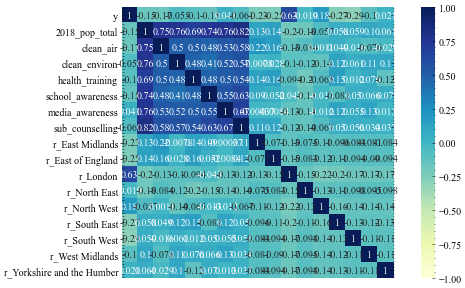

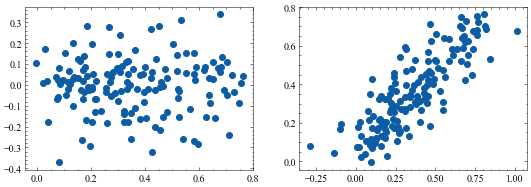

In [209]:
y = {"method":"ratedelta",
     "var" : ["2018_cases_total","2018_pop_total","2008_cases_total","2008_pop_total"]}

dicx = {}
dicx["source"]  = {}
dicx["log"] = {'2018_pop_total':"2018_pop_total",
               #"total_budget" : "total_budget",
               'clean_air':'clean_air', 
               'clean_environ':'clean_environ',
               'health_training':'health_training',
               'school_awareness': 'school_awareness',
               'media_awareness':'media_awareness', 
               'sub_counselling':'sub_counselling'
              }
dicx["category"] ={'r':"region"}
dicx["rate"] = {} #{'clean_air':"total_budget","clean_environ":"total_budget"}
print(f"variables:{dicx},\ny:{y}")

dft = transform_for_regression(dfs,y,dicx)


corr = dft.corr()
f, ax = plt.subplots(figsize=(10, 5))
ax = sns.heatmap(corr,yticklabels=True, annot=True,cmap="YlGnBu",
                 vmin=-1, vmax=1,xticklabels=False, square=True)
    
print("++"*60)

## drop
dft_selected = drop_column_using_vif_(dft.drop('y', axis=1),5)
print(dft_selected.columns)
print("++"*60)

## model
# 投资为0，y应该不变，不需要常数项 hasconst表示是否有变量是常数
model = sm.OLS(endog=dft[["y"]], exog=sm.add_constant(dft_selected),hasconst=False).fit() ## is variable constant?
print(model.summary())

## residual
print("++"*60)
fig, ax = plt.subplots(1,2,figsize=(9,3))
ax[0].scatter(model.fittedvalues, model.resid)
ax[1].scatter(dft["y"],model.fittedvalues)

## 模型二 ： 2018 案例数

variables:{'source': {}, 'log': {'2018_pop_total': '2018_pop_total', 'total_budget': 'total_budget'}, 'category': {'r': 'region', 'lcattype': 'local_authority_type'}, 'rate': {}},
y:{'method': 'log', 'var': '2018_cases_total'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Dropping: r_East Midlands
 VIF_value:inf
Dropping: r_London
 VIF_value:inf
Dropping: lcattype_london_borough
 VIF_value:inf
Dropping: 2018_pop_total
 VIF_value:32.847825570402776
Dropping: lcattype_metropolitan_borough
 VIF_value:5.893881877166915
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:            

D:\Miniconda\envs\sds20\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
D:\Miniconda\envs\sds20\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
D:\Miniconda\envs\sds20\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
D:\Miniconda\envs\sds20\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
D:\Miniconda\envs\sds20\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
D:\Miniconda\envs\sds20\lib\site-packages\statsmodels\stats\outliers_influen

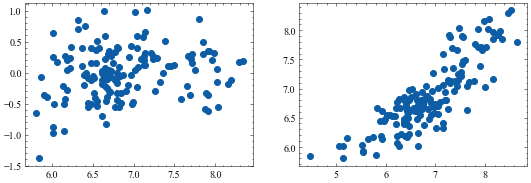

In [12]:
y = {"method":"log",
     "var" : "2018_cases_total"}
dicx = {}
dicx["source"]  = {}
dicx["log"] = {'2018_pop_total':"2018_pop_total",
               "total_budget" : "total_budget",
              }
dicx["category"] ={'r':"region","lcattype" : "local_authority_type"}
dicx["rate"] = {} #{'clean_air':"total_budget","clean_environ":"total_budget"}
print(f"variables:{dicx},\ny:{y}")

dft = transform_for_regression(dfs,y,dicx)
print("++"*60)

## drop
dft_selected = drop_column_using_vif_(dft.drop('y', axis=1),5)

print("++"*60)

## model
model = sm.OLS(endog=dft[["y"]], exog=dft_selected, hasconst=False).fit()
print(model.summary())

## residual
print("++"*60)
fig, ax = plt.subplots(1,2,figsize=(9,3))
    
ax[0].scatter(model.fittedvalues, model.resid)
ax[1].scatter(dft["y"],model.fittedvalues)

# Plots 

## 时序幂律

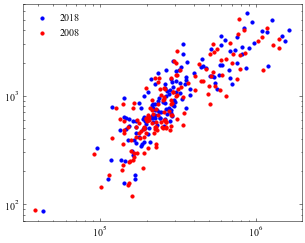

In [13]:

fig, ax = plt.subplots(figsize=(5,4))

ax.set_yscale("log")
ax.set_xscale("log")

dx1 = np.array(dfs["2018_pop_total"])
dy1 = np.array(dfs["2018_cases_total"])

dx2 = np.array(dfs["2008_pop_total"])
dy2 = np.array(dfs["2008_cases_total"])

mksize = 10 ## marker color
ax.scatter(dx1,dy1,s=mksize,c="b",label="2018")
ax.scatter(dx2,dy2,s=mksize,c="r",label="2008")
ax.legend(frameon=False)


In [14]:
def scatterplot(df,x="2018_pop_total",y="2018_cases_total",):
    #plt.style.use("ggplot")
    fig, ax = plt.subplots(1,3,figsize=(9,3),dpi=400)
    
    ax[1].set_yscale("log")
    
    ax[2].set_yscale("log")
    ax[2].set_xscale("log")
  
    dx = np.array(df[x])
    dy = np.array(df[y])
    
    mksize = 3 ## marker color
    ax[0] = ax[0].scatter(dx,dy,s=mksize)
    ax[1] = ax[1].scatter(dx,dy,s=mksize)
    ax[2] = ax[2].scatter(dx,dy,s=mksize)
    return ax

array([<matplotlib.collections.PathCollection object at 0x00000211FF8F9A90>,
      dtype=object)

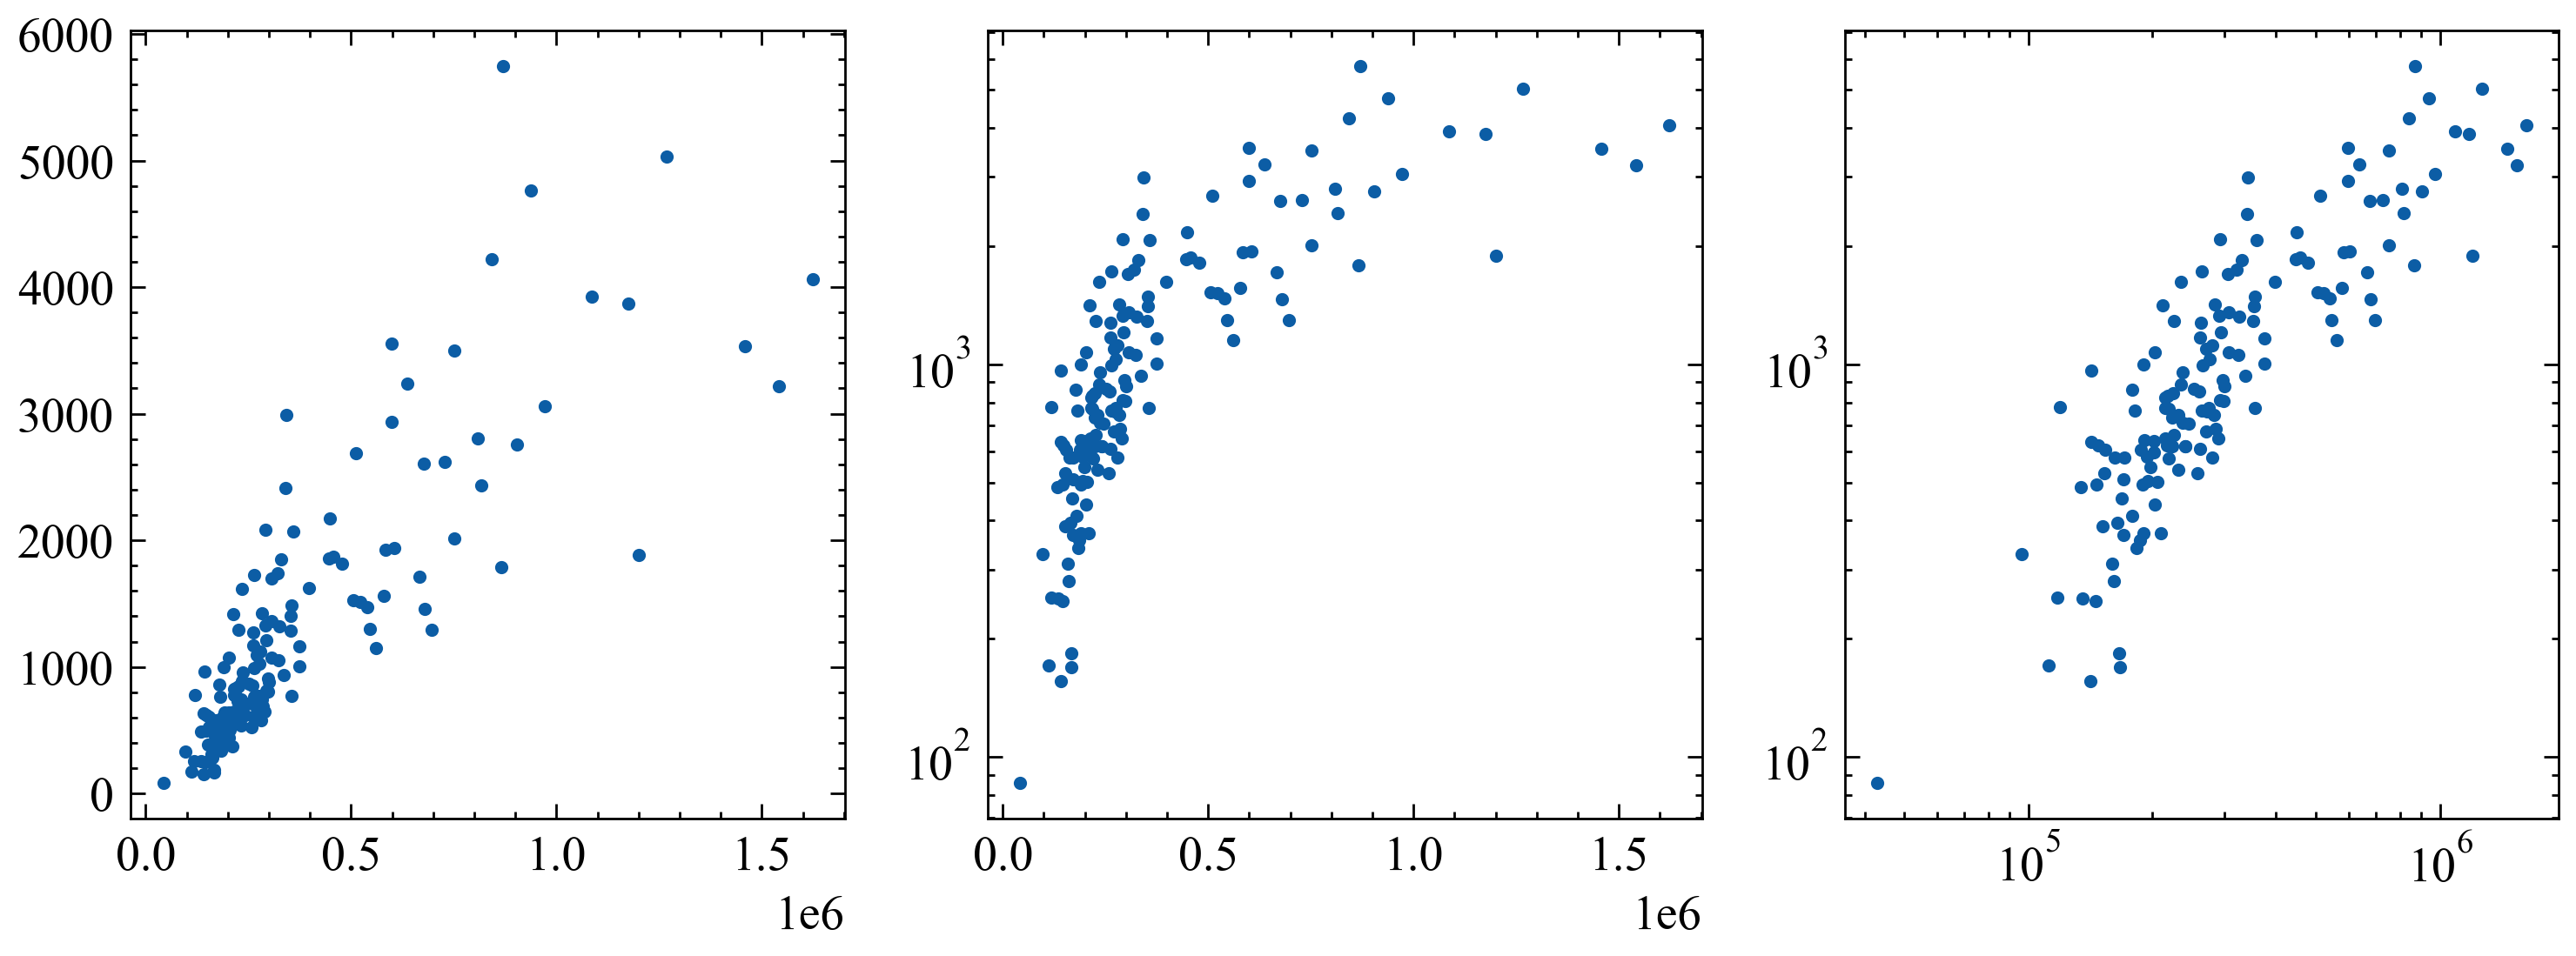

In [15]:
scatterplot(dfs,x="2018_pop_total",y="2018_cases_total")

In [16]:
sps.boxcox(dfs['total_budget'].astype(np.float))[1]

-0.42990722717361135

## loglog plot

In [17]:
def loglogplot(x,y,labelx="LogPop",labely="LogArea",ax=ax,locator=(0.1,0.9),leloc=(0.9,0.9)):
    xd,yd=np.log10(x),np.log10(y)
    # make the scatter plot
    #fig, ax = plt.subplots(figsize=(5,4),dpi=200)

    ax.set_yscale("log")
    ax.set_xscale("log")
    #ax.set_ylim(1e1,10**3.4)
    #ax.set_xlim(10**(-0.1),10**(2.5))
    # determine best fit line
    par = np.polyfit(xd, yd, 1,full=True)

    slope=par[0][0]
    intercept=par[0][1]

    xl = [min(xd), max(xd)]
    yl = [slope*xx + intercept  for xx in xl]
    ax.plot([10**xx for xx in xl],[10**yy for yy in yl], '-b')

    # coefficient of determination, plot text
    variance = np.var(yd)#方差
    residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)])#残差

    Rsqr = np.round(1-residuals/variance, decimals=2)
    #ax.text(0.3*max(x),1.2*max(y),r'$R^2 ={0.2f} \n Slope={0.2f}'.format{Rsqr,slope.round(2)}, fontsize=15)
    ax.text(leloc[0]*max(x),leloc[1]*min(y),f'$R^2$={Rsqr:0.2f}\nSlope={slope:.2f}\nIntercept={intercept:.2f}', fontsize=10)
    print(variance,residuals)
    ax.set_xlabel(labelx)
    ax.set_ylabel(labely)

    # error bounds
    yerr = [abs(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)]
    par = np.polyfit(xd, yerr, 2, full=True)
    erro_x2 = par[0][0]
    erro_x1 = par[0][1]
    erro_x0 = par[0][2]
    yerrUpper = [(xx*slope+intercept)+(erro_x2*xx**2 + erro_x1*xx + erro_x0) for xx,yy in zip(xd,yd)]
    yerrLower = [(xx*slope+intercept)-(erro_x2*xx**2 + erro_x1*xx + erro_x0) for xx,yy in zip(xd,yd)]
    print(erro_x2, erro_x1, erro_x0)

    #     ax.plot([10**xx for xx in xd],[10**yy for yy in yerrLower], 'm')
    #     ax.plot([10**xx for xx in xd],[10**yy for yy in yerrUpper], 'm')
    ax.scatter(x, y, s=6, alpha=1, marker='h',color="orangered")

    yline = [slope*xl[0] + intercept,xl[1] + intercept]
    #yline2 = [xl[0] + intercept,slope*xl[1] + intercept]
    ax.plot([10**xx for xx in xl],[10**yy for yy in yline], '--m')
    #ax.plot([10**xx for xx in xl],[10**yy for yy in yline2], '--m')
    ax.text(locator[0]*max(x),locator[1]*max(y), "Slope=1", size = 10,\
            #family = "fantasy", style = "italic"
            color = "m", weight = "light",\
            )#bbox = dict(facecolor = "r", alpha = 0.2)
    return slope,ax

* 超线性

## Figure 1

In [98]:
## TODO: 应该先stack再计算
dfc_rate = dfc.iloc[index[index==False].index,:19]
dfc_rate[("2008","male")] =  dfc_rate.apply(lambda x : 1000*(x["2008_cases_male"]/x["2008_pop_male"]), axis=1)
dfc_rate[("2013","male")] =  dfc_rate.apply(lambda x : 1000*(x["2013_cases_male"]/x["2013_pop_male"]), axis=1)
dfc_rate[("2018","male")] =  dfc_rate.apply(lambda x : 1000*(x["2018_cases_male"]/x["2018_pop_male"]), axis=1)
dfc_rate[("2008","female")] =  dfc_rate.apply(lambda x : 1000*(x["2008_cases_female"]/x["2008_pop_female"]), axis=1)
dfc_rate[("2013","female")] =  dfc_rate.apply(lambda x : 1000*(x["2013_cases_female"]/x["2013_pop_female"]), axis=1)
dfc_rate[("2018","female")] =  dfc_rate.apply(lambda x : 1000*(x["2018_cases_female"]/x["2018_pop_female"]), axis=1)
dfc_rate = dfc_rate.iloc[:,-6:].stack().reset_index().rename(columns={0:"rate"})
dfc_rate["year"] = dfc_rate.apply(lambda x :tuple(x["level_1"])[0], axis=1)
dfc_rate["sex"] = dfc_rate.apply(lambda x :tuple(x["level_1"])[1], axis=1)

In [97]:
## TODO: 应该先stack再计算
dfc_bud = dfc.iloc[index[index==False].index,19:-2]
dfc_bud["Clean Air "] =  dfc_bud.apply(lambda x : 100*(x["clean_air"]/x["total_budget"]), axis=1)
dfc_bud["Clean Environment"]  =  dfc_bud.apply(lambda x : 100*(x["clean_environ"]/x["total_budget"]), axis=1)
dfc_bud["Health Training"] =  dfc_bud.apply(lambda x : 100*(x["health_training"]/x["total_budget"]), axis=1)
dfc_bud["School Awareness"] =  dfc_bud.apply(lambda x : 100*(x["school_awareness"]/x["total_budget"]), axis=1)
dfc_bud["Media Awareness"] =  dfc_bud.apply(lambda x : 100*(x["media_awareness"]/x["total_budget"]), axis=1)
dfc_bud["Sub Counselling"] =  dfc_bud.apply(lambda x : 100*(x["sub_counselling"]/x["total_budget"]), axis=1)
dfc_bud = dfc_bud.iloc[:,-6:]
dfc_bud = dfc_bud.stack().reset_index()

In [102]:
dfc[index]

,local_authority_area,2008_cases_total,2013_cases_total,2018_cases_total,2008_pop_total,2013_pop_total,2018_pop_total,2008_cases_male,2013_cases_male,2018_cases_male,...,2018_pop_female,total_budget,clean_air,clean_environ,health_training,school_awareness,media_awareness,sub_counselling,region,local_authority_type
25,City of London,16,14,12,11378,9838,8107,5,3,3,...,3711,50000,12000,9000,6000,20000,2000,1000,London,other_london
59,Isles of Scilly,5,1,4,2200,2385,2440,2,0,1,...,1014,2000,0,0,0,2000,0,0,South West,unitary_authority
105,Rutland,88,102,86,38363,39872,42952,28,23,26,...,19756,51000,17000,5000,8000,14000,5000,2000,East Midlands,unitary_authority


0.17311333832419748 0.027848423307127446
-0.0049551712955259244 0.04950913501393977 0.010412955708722258


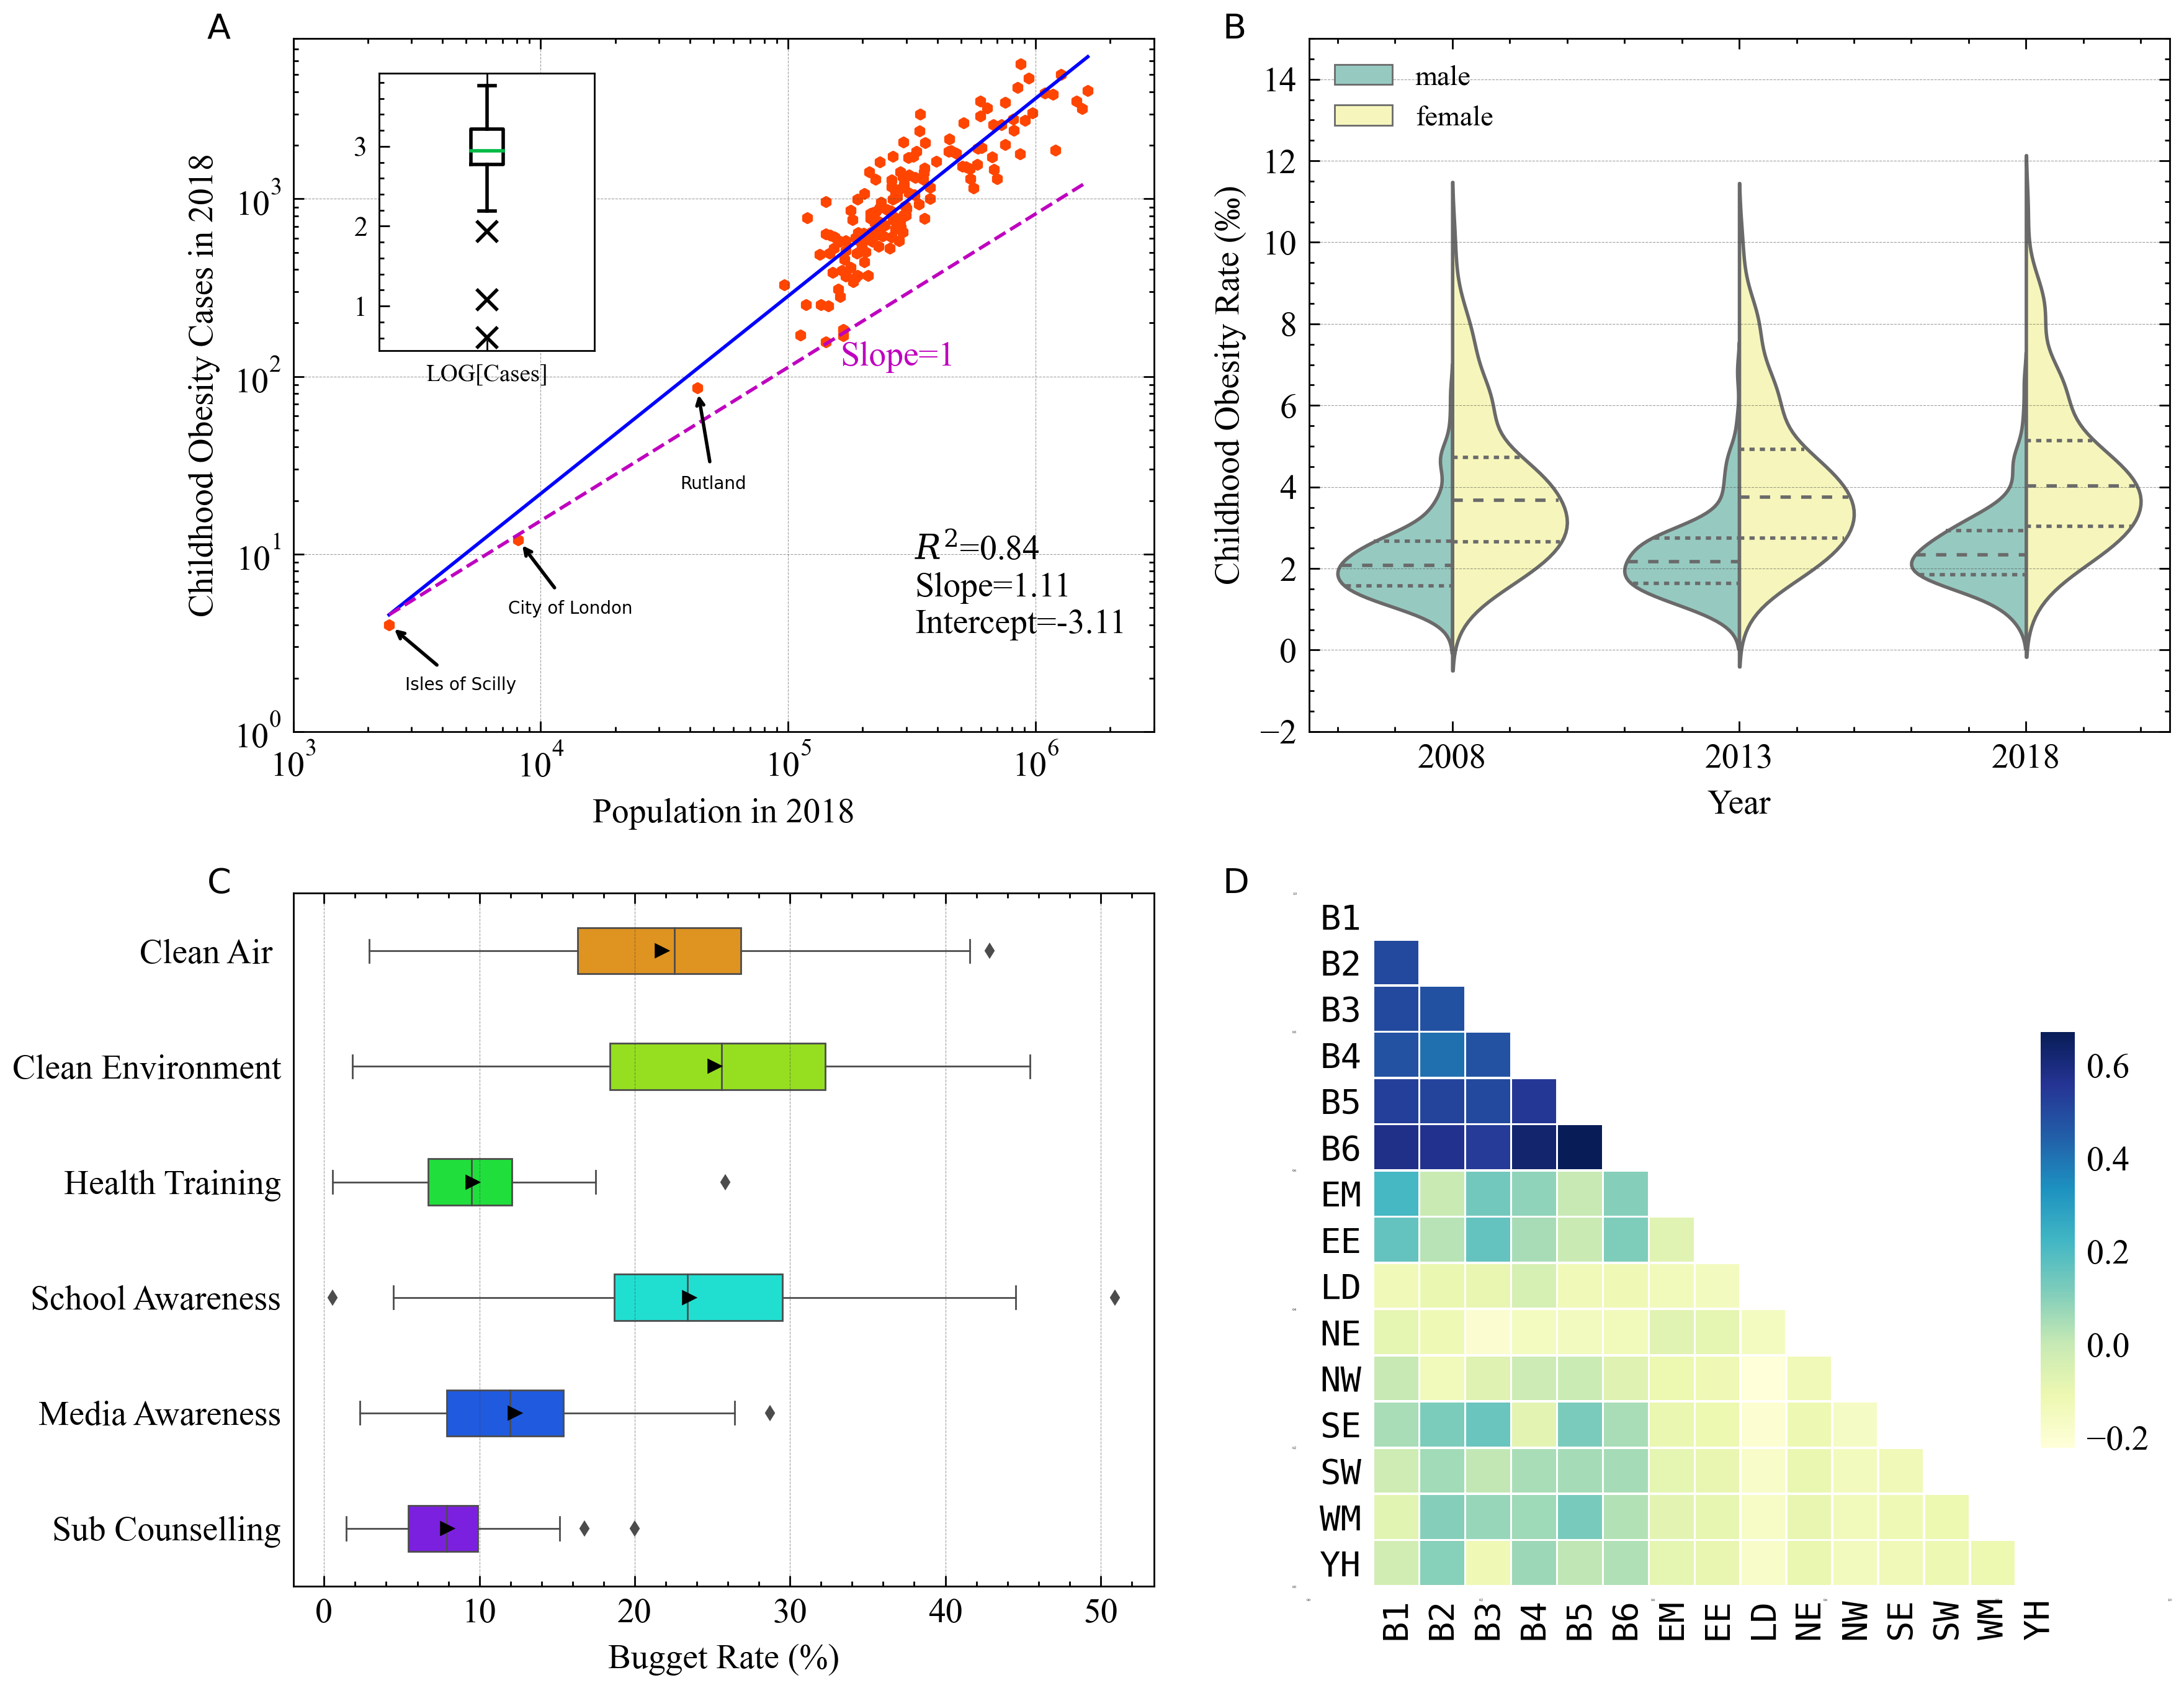

In [141]:
font1 = {'family' : 'sans-serif','weight' : 'normal','size'   : 5}
font2 = {'family' : 'sans-serif','weight' : 'normal','size'   : 10}
fig = plt.figure(figsize=(9, 7),dpi=400)

## ============================================================================
ax1 = fig.add_subplot(221)
#ax1.text(0.3*min(x),1.15*max(y),"A",font=font1)

x = dfc["2018_pop_total"].astype(np.float)
y = dfc["2018_cases_total"].astype(np.float)

ax1.grid(linestyle="--", linewidth=0.2, color='.25',alpha=0.5)# zorder=50
loglogplot(x,y,labelx="Population in 2018",labely="Childhood Obesity Cases in 2018",ax=ax1,locator = (0.1,0.02),leloc=(0.2,0.9))

ax1.annotate("City of London",(8107,12),xytext=(0.25,0.17),textcoords = "axes fraction",font=font1,arrowprops=dict(facecolor='black',arrowstyle="->"))
ax1.annotate("Isles of Scilly",(2440,4),xytext=(0.13,0.06),textcoords = "axes fraction",font=font1,arrowprops=dict(facecolor='black',arrowstyle="->")) 
ax1.annotate("Rutland",(42952,86),xytext=(0.45,0.35),textcoords = "axes fraction",font=font1,arrowprops=dict(facecolor='black',arrowstyle="->")) 
#https://www.youtube.com/watch?v=xLw9wf9uNuw
ax1.set_xlim(1e3,3e6)
ax1.set_ylim(1e0,8e3)
ax1x = ax1.inset_axes([0.1, 0.55, 0.25, 0.4])

ax1x.set_xlabel("LOG[Cases]",size=7)
ax1x.boxplot(np.log10(y),sym="x")
ax1x.tick_params(axis=u'both',which=u'both',labelright=0,labelleft =1,labelbottom=0,right=0,labelsize=8)

## ==========================================================================
ax2 = fig.add_subplot(222)

ax2.grid(linestyle="--", linewidth=0.2, color='.25', alpha=0.5) # zorder=50
sns.violinplot(data = dfc_rate, x="year",y="rate", hue="sex",palette="Set3", split=True,
                    scale="count", inner="quartile",ax=ax2, 
               #estimator=np.mean
              )
ax2.set_ylim(-2,15)
ax2.set_xlabel("Year")
ax2.set_ylabel("Childhood Obesity Rate (‰)")
ax2.legend(loc=2,fontsize= 'small')


## ==========================================================================
ax3 = fig.add_subplot(224, frameon=0,)
ax3.tick_params(axis=u'both', which=u'both',length=0,labelsize=0)
ax3h = ax3.inset_axes([0, 0, 0.95, 1])
ax3h.tick_params(axis=u'both', which=u'both',length=0,labelsize=10)
ax3x = ax3.inset_axes([0.85, 0.2, 0.04, 0.6])
ax3x.tick_params(axis=u'both', which=u'both',length=0,labelsize=10)

dfcorr = dft[['clean_air', 'clean_environ','health_training', 'school_awareness', 'media_awareness','sub_counselling', 'r_East Midlands', 'r_East of England', 'r_London','r_North East', 'r_North West', 'r_South East', 'r_South West',
       'r_West Midlands', 'r_Yorkshire and the Humber']]
dfcorr.columns = [ 'B1', 'B2',"B3","B4","B5","B6","EM", 'EE', 'LD','NE', 'NW', 'SE', 'SW','WM', 'YH']

mask = np.zeros_like(dfcorr.corr())
mask[np.triu_indices_from(mask)] = True
ax3h = sns.heatmap(dfcorr.corr(),mask=mask,square=True,annot=False,fmt="> 0.1f", linewidths=.5, ax=ax3h,yticklabels=1, xticklabels=1,
             cmap="YlGnBu",cbar_ax=ax3x)

labels = ax3h.get_xticklabels() + ax3h.get_yticklabels()
[label.set_fontname('monospace') for label in labels] ## 等宽无衬线字体
#ax3h.set_xlabel("Variables",labelpad=1.1)
## ==========================================================================
ax4 = fig.add_subplot(223)

ax4.grid(linestyle="--", linewidth=0.2, color='.25', alpha=0.5)
sns.boxplot(data = dfc_bud, y="level_1",x=0,ax=ax4,palette="gist_rainbow",sym=",",width=0.4,fliersize=2,linewidth=0.5, showmeans=True,
            meanprops={"marker":">",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"3"})
ax4.set_ylabel("")
ax4.set_xlabel("Bugget Rate (%)")
ax4.tick_params(axis="y",which=u'both',length=0,labelsize=10)

## ==========================================================================

ax1.text(-0.1,1,"A",font=font2, transform=ax1.transAxes)
ax2.text(-0.1,1,"B",font=font2, transform=ax2.transAxes)

ax3.text(-0.1,1,"D",font=font2, transform=ax3.transAxes)
ax4.text(-0.1,1,"C",font=font2, transform=ax4.transAxes)

plt.tight_layout()
fig.savefig("fig1.png",dpi=400)

## tests

### 幂律的时序变化

In [ ]:
18 1.11
13: 1.19
08: 1.10

0.16756541068760408 0.034048353756682526
-0.019420776620798587 0.17984185687882828 -0.2539885177883138


(1.1040759936743323,
 <AxesSubplot:xlabel='Population in 2018', ylabel='Cases in 2018'>)

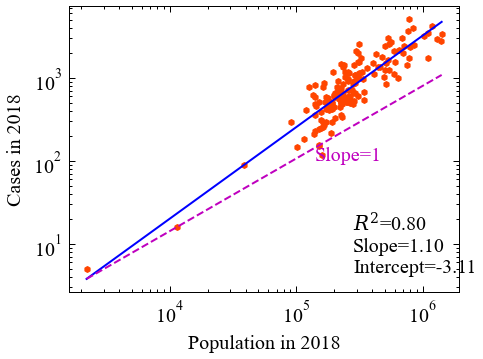

In [303]:
fig,ax = plt.subplots()
x = dfc["2008_pop_total"].astype(np.float)
y = dfc["2008_cases_total"].astype(np.float)
loglogplot(x,y,labelx="Population in 2018",labely="Cases in 2018",ax=ax,locator = (0.1,0.02),leloc=(0.2,0.9))

In [ ]:
fig,ax = plt.subplots()

### 发病率与规模的关系

In [374]:
dfc.columns

Index(['local_authority_area', '2008_cases_total', '2013_cases_total',
       '2018_cases_total', '2008_pop_total', '2013_pop_total',
       '2018_pop_total', '2008_cases_male', '2013_cases_male',
       '2018_cases_male', '2008_pop_male', '2013_pop_male', '2018_pop_male',
       '2008_cases_female', '2013_cases_female', '2018_cases_female',
       '2008_pop_female', '2013_pop_female', '2018_pop_female', 'total_budget',
       'clean_air', 'clean_environ', 'health_training', 'school_awareness',
       'media_awareness', 'sub_counselling', 'region', 'local_authority_type'],
      dtype='object')

0.06848366941649019 0.0026091888198439108
0.059842338463088854 -0.6797132100332461 1.964385805924625


(0.9441704665793327,
 <AxesSubplot:xlabel='Population in 2018', ylabel='Cases in 2018'>)

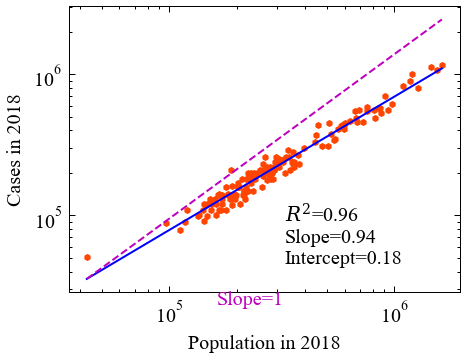

In [379]:
fig,ax = plt.subplots()
x = dfc.loc[~index,"2018_pop_total"].astype(np.float)
y = dfc.loc[~index,"total_budget"].astype(np.float)
#ax.scatter(np.log(x),y)
loglogplot(x,y,labelx="Population in 2018",labely="Cases in 2018",ax=ax,locator = (0.1,0.02),leloc=(0.2,0.9))

In [31]:
dfc.columns

Index(['local_authority_area', '2008_cases_total', '2013_cases_total',
       '2018_cases_total', '2008_pop_total', '2013_pop_total',
       '2018_pop_total', '2008_cases_male', '2013_cases_male',
       '2018_cases_male', '2008_pop_male', '2013_pop_male', '2018_pop_male',
       '2008_cases_female', '2013_cases_female', '2018_cases_female',
       '2008_pop_female', '2013_pop_female', '2018_pop_female', 'total_budget',
       'clean_air', 'clean_environ', 'health_training', 'school_awareness',
       'media_awareness', 'sub_counselling', 'region', 'local_authority_type'],
      dtype='object')

### 预算的分配比例

In [95]:
dfc_bud = dfc.iloc[index[index==False].index,19:-2]
dfc_bud["Clean Air "] =  dfc_bud.apply(lambda x : 100*(x["clean_air"]/x["total_budget"]), axis=1)
dfc_bud["Clean Environment"]  =  dfc_bud.apply(lambda x : 100*(x["clean_environ"]/x["total_budget"]), axis=1)
dfc_bud["Health Training"] =  dfc_bud.apply(lambda x : 100*(x["health_training"]/x["total_budget"]), axis=1)
dfc_bud["School Awareness"] =  dfc_bud.apply(lambda x : 100*(x["school_awareness"]/x["total_budget"]), axis=1)
dfc_bud["Media Awareness"] =  dfc_bud.apply(lambda x : 100*(x["media_awareness"]/x["total_budget"]), axis=1)
dfc_bud["Sub Counselling"] =  dfc_bud.apply(lambda x : 100*(x["sub_counselling"]/x["total_budget"]), axis=1)
dfc_bud = dfc_bud.iloc[:,-6:]
dfc_bud = dfc_bud.stack().reset_index()

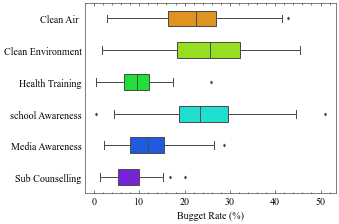

In [88]:
fig,ax = plt.subplots(figsize=(4.5,3.5))
sns.boxplot(data = dfc_bud, y="level_1",x=0,ax=ax,palette="gist_rainbow",sym=",",width=0.5,fliersize=2)
ax.set_ylabel("")
ax.set_xlabel("Bugget Rate (%)")
ax.tick_params(axis="y",which=u'both',length=0,labelsize=10)

# 后模型

In [219]:
X = dft.drop(["y","2018_pop_total","r_East Midlands"],axis=1)
df_with_const = add_constant(X)
vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()
vif_df = vif_df.drop('const')
vif_df.round(3).to_csv("vif.csv")
vif_df

,VIF
clean_air,1.9900
clean_environ,1.8366
health_training,1.8369
school_awareness,1.9285
media_awareness,2.2565
sub_counselling,2.6720
r_East of England,2.0772
r_London,3.9467
r_North East,2.3465
r_North West,3.2260


In [148]:
results = pd.DataFrame(model.summary().tables[1])
results.to_csv("table1.csv")
#pd.read_html(results_as_html, header=0, index_col=0)[0]

## Figure 2

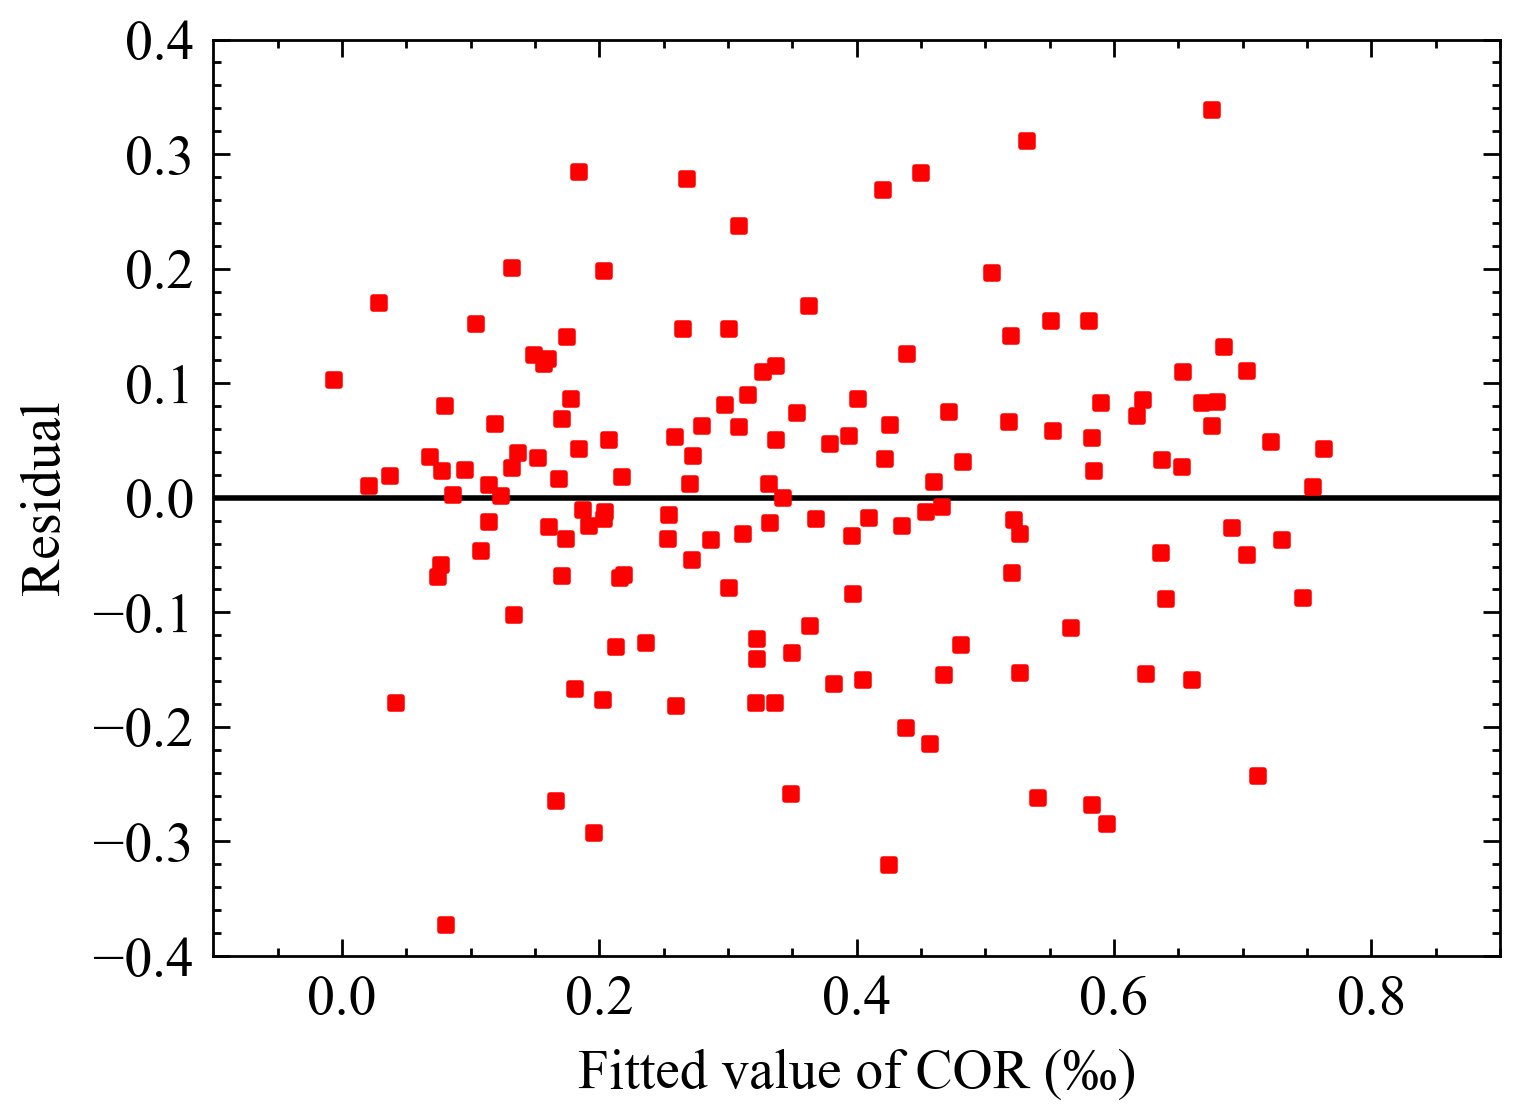

In [197]:
fig= plt.figure(figsize=(4,3),dpi=400)

ax1 = fig.add_subplot(111)
ax1.plot([-1,1],[0,0],zorder=40,c="black")
ax1.scatter(model.fittedvalues, model.resid,s=5,marker=",",c="r",zorder=41)
ax1.set_xlim(-0.1,0.9)
ax1.set_ylim(-0.4,0.4)
ax1.set_xlabel("Fitted value of COR (‰)")
ax1.set_ylabel("Residual")

# ax2 = fig.add_subplot(122)
# ax2.scatter(dft["y"],model.fittedvalues,s=5)
# ax2.set_xlim(-0.4,1.1)
# ax2.set_ylim(-0.4,1.1)
# ax2.set_xlabel("COR value (‰)")
# ax2.set_ylabel("Fitted value of COR (‰)")
# ax2.plot([-0.4,1],[-0.4,1])

plt.tight_layout()
fig.savefig("fig2.png",dpi=400)


# TODOs

* 用SAMI评价表现会怎么样
* 交互项设计  直接原因与间接原因导致时，
* 对数化cases pop 和budget的R2就有0.997
* 是否可以对Region 类别进行归并,  没找到英国常用的研究分区。
* Region 和 local_authority_type 有一个london 存在共线性

* 增长型的残差说明什么

回答了基本问题:
* 直接用双对数轴回归可以判断是哪种关系 线性，幂律，指数
* 自变量不需要完全不相关，只要不存在共线性就行
* 超线性与次线性指数是如何与线性相关系数相关联的
* 